# ResNet-18 usando PyTorch Lightning
## Objetivos

- Importar un modelo CNN complejo
- Entrenar el modelo para clasificacion de imagenes


## Instalar e importar bibliotecas


In [1]:
import numpy as np
import os
%matplotlib inline
import matplotlib.pyplot as plt
import time
import pandas as pd


import torch.optim as optim
from torchmetrics import Accuracy
from torchvision import datasets, transforms, models

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import pytorch_lightning as pl
import torchmetrics

from torchvision.models import resnet50, ResNet50_Weights, resnet18, ResNet18_Weights
from collections import Counter
from torchvision import datasets
from torchvision import transforms
from torch.utils.data import DataLoader
from torch.utils.data.dataset import random_split

from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping
from pytorch_lightning.loggers import CSVLogger
from pytorch_lightning.callbacks import TQDMProgressBar, RichProgressBar


In [2]:
BATCH_SIZE = 32
NUM_EPOCHS = 5
LEARNING_RATE = 0.001
NUM_WORKERS = 223
CLASES = 10

In [ ]:
DEBUG_MODE = False  # True Debug, False Full
 
if DEBUG_MODE:
    BATCH_SIZE = 4
    NUM_EPOCHS = 2
    print("Modo depuración activado: usando dataset ligero y parámetros reducidos.")
else:
    BATCH_SIZE = 32
    NUM_EPOCHS = 60
    print("Modo completo activado: usando configuración completa.")
 

Modo completo activado: usando configuración completa.


## Preparación de la base de datos:

### Fashion MNIST contiene 60k RGB imágenes de 32x32x3 pixeles distribuidas en 10 clases.

*   Grupo de entrenamiento: 50K imágenes
*   Grupo de evaluación: 10k imágenes

In [4]:
# Descargamos dataset
 
if DEBUG_MODE:
    train_dataset = torchvision.datasets.FashionMNIST(
        root="./data", train=True, transform=transforms.ToTensor(), download=True)
 
    test_dataset = datasets.FashionMNIST(
        root="./data", train=False, transform=transforms.ToTensor(), download=True)
else:
    train_dataset = torchvision.datasets.FashionMNIST(
        root="./data", train=True, transform=transforms.ToTensor(), download=True)
 
    test_dataset = datasets.FashionMNIST(
        root="./data", train=False, transform=transforms.ToTensor(), download=True)

In [5]:
# Definimos dataloaders para los datasets

train_loader = DataLoader(dataset=train_dataset,
                          batch_size=BATCH_SIZE,
                          num_workers=NUM_WORKERS,
                          drop_last=False, # ignora el último batch si el número de muestras no son divisibles para el tamaño de batch
                          shuffle=True)

test_loader = DataLoader(dataset=test_dataset,
                          batch_size=BATCH_SIZE,
                          num_workers=NUM_WORKERS,
                          drop_last=False,
                          shuffle=False)

In [6]:
print("Número de muestras de entrenamiento:", len(train_dataset))
print("Número de muestras de evaluación:", len(test_dataset))


Número de muestras de entrenamiento: 60000
Número de muestras de evaluación: 10000


In [7]:
# Create a slice: e.g., first 1000 samples
subset = torch.utils.data.Subset(train_dataset, range(1000))
 
# Now you can use `subset` like a normal dataset
print(len(subset))  # Output: 1000

1000


In [8]:
print("Número de iteraciones por época:", len(train_loader))
# 1563*32 = 50000
# 3152*16 = 50000

Número de iteraciones por época: 3750


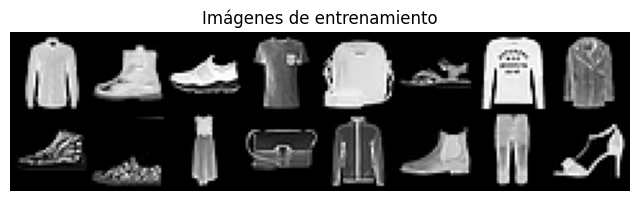

In [9]:
# Visualización de imágenes

for images, labels in train_loader:
    break

plt.figure(figsize=(8, 8))
plt.axis("off")
plt.title("Imágenes de entrenamiento")
plt.imshow(np.transpose(torchvision.utils.make_grid(
    images[:64],
    padding=2,
    normalize=True),
    (1, 2, 0)))
plt.show()

In [10]:
# Dimensión de cada imagen
print("Dimensión de entrada:", images.shape) # (batch_size, channels_in, W, H)

Dimensión de entrada: torch.Size([16, 1, 28, 28])


In [ ]:
class FMNIST_DataModule(pl.LightningDataModule):
    def __init__(self, data_path="./", batch_size=64, num_workers=223):
        super().__init__()
        self.data_path = data_path
        self.batch_size = batch_size
        self.num_workers = num_workers
        self.pin_memory = torch.cuda.is_available()

        self.train_transform = torchvision.transforms.Compose([
            torchvision.transforms.Grayscale(num_output_channels=3),
            torchvision.transforms.RandomHorizontalFlip(p=0.5),
            torchvision.transforms.Resize((224, 224)),
            torchvision.transforms.ToTensor(),
            torchvision.transforms.Normalize(mean=[0.485]*3, std=[0.229]*3)
        ])

        self.test_transform = torchvision.transforms.Compose([
            torchvision.transforms.Grayscale(num_output_channels=3),
            torchvision.transforms.Resize((224, 224)),
            torchvision.transforms.ToTensor(),
            torchvision.transforms.Normalize(mean=[0.485]*3, std=[0.229]*3)
        ])

    def prepare_data(self):
        # Descarga
        datasets.FashionMNIST(root=self.data_path, train=True, download=True)
        datasets.FashionMNIST(root=self.data_path, train=False, download=True)

    def setup(self, stage=None):
        if stage in (None, "fit"):
            train_full = datasets.FashionMNIST(
                root=self.data_path, train=True, transform=self.train_transform, download=False
            )
            n_total = len(train_full)
            n_val = int(0.1 * n_total)
            n_train = n_total - n_val
            g = torch.Generator().manual_seed(42)  # split reproducible
            self.train, self.valid = random_split(train_full, lengths=[n_train, n_val], generator=g)

        if stage in (None, "test"):
            self.test = datasets.FashionMNIST(
                root=self.data_path, train=False, transform=self.test_transform, download=False
            )

    def train_dataloader(self):
        return DataLoader(
            dataset=self.train,
            batch_size=self.batch_size,
            shuffle=True,
            drop_last=True,
            num_workers=self.num_workers,
            pin_memory=self.pin_memory,
            persistent_workers=(self.num_workers > 0),
        )

    def val_dataloader(self):
        return DataLoader(
            dataset=self.valid,
            batch_size=self.batch_size,
            shuffle=False,
            drop_last=False,
            num_workers=self.num_workers,
            pin_memory=self.pin_memory,
            persistent_workers=(self.num_workers > 0),
        )

    def test_dataloader(self):
        return DataLoader(
            dataset=self.test,
            batch_size=self.batch_size,
            shuffle=False,
            drop_last=False,
            num_workers=self.num_workers,
            pin_memory=self.pin_memory,
            persistent_workers=(self.num_workers > 0),
        )


In [12]:
# Inicizalización de DataModule

torch.manual_seed(47)  # especificamos un random seed para reproducibilidad de inicializaciones aleatorias
data_module = FMNIST_DataModule(data_path='./data')

In [13]:
# pytorch_model = torch.hub.load('pytorch/vision:v0.11.0', 'resnet50', weights="IMAGENET1K_V1") 
# o "IMAGENET1K_V2" según la versión)
# modelo sin pre-entrenamiento

In [14]:
# pytorch_model

In [15]:
# Inicialización del modulo lightning

callback_check = ModelCheckpoint(save_top_k=1, mode="max", monitor="valid_acc") # guardamos el mejor modelo monitoreado en la acc de validación. Por qué no la de entrenamiento?

callback_tqdm = RichProgressBar(leave=True)

early_stop_callback = EarlyStopping(
    monitor='valid_loss',           # Metric to monitor
    min_delta=0.00,               # Minimum change to qualify as improvement
    patience=10,                   # Number of epochs with no improvement after which training will stop
    verbose=True,                 # Print messages when stopping
    mode='min'                    # Direction of improvement ('min' for loss, 'max' for accuracy)
)

logger = CSVLogger(save_dir="logs/", name="complex-cnn-fmnist")

In [16]:
class ResNet18TransferLearning(pl.LightningModule):
    def __init__(self, num_classes=10, learning_rate=1e-3):
        super().__init__()
        self.save_hyperparameters()
 
        # Load pre-trained ResNet50
        self.model = models.resnet18(pretrained=True)
 
        # Modify the first layer to accept 3-channel input (already handled via Grayscale(3))
        # Modify the final classifier layer
        in_features = self.model.fc.in_features
        self.model.fc = nn.Linear(in_features, num_classes)

        for param in self.model.parameters():
            param.requires_grad = False
        for param in self.model.fc.parameters():
            param.requires_grad = True
 
        # Loss and metric
        self.criterion = nn.CrossEntropyLoss()
        self.accuracy = Accuracy(task='multiclass', num_classes=num_classes)
        self.test_acc = Accuracy(task='multiclass', num_classes=num_classes)
 
    def forward(self, x):
        return self.model(x)

    def _shared_step(self, batch, stage):
        x, y = batch
        logits = self(x)
        loss = F.cross_entropy(logits, y)
        preds = logits.argmax(1)
        out = (loss, y, preds)
        assert all(v is not None for v in out), "shared_step devolvió None"
        return out
    
    def training_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = self.criterion(logits, y)
        acc = self.accuracy(logits, y)
        self.log('train_loss', loss, on_step=False, on_epoch=True)
        self.log('train_acc', acc, on_step=False, on_epoch=True)
        return loss
 
    def validation_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = self.criterion(logits, y)
        acc = self.accuracy(logits, y)
        self.log('valid_loss', loss, prog_bar=True)
        self.log('valid_acc', acc, prog_bar=True)

    def test_step(self, batch, batch_idx):
        loss, true_labels, predicted_labels = self._shared_step(batch, stage="test")
        self.test_acc(predicted_labels, true_labels)
        self.log("test_acc", self.test_acc, on_epoch=True, on_step=False)
 
    def configure_optimizers(self):
        return optim.Adam(self.model.fc.parameters(), lr=self.hparams.learning_rate)
        # Only fine-tune the classifier (faster), or use self.parameters() to fine-tune whole network

In [17]:
# Instantiate model
pytorch_model = ResNet18TransferLearning(num_classes=10, learning_rate=1e-3)
pytorch_model

# Trainer
trainer = pl.Trainer(
    max_epochs=500,
    accelerator='gpu' if torch.cuda.is_available() else 'cpu',
    devices='auto',
    log_every_n_steps=100,
    logger=logger,
    callbacks=[callback_check, callback_tqdm, early_stop_callback]
)

datamodule = FMNIST_DataModule()

# Train
trainer.fit(pytorch_model, datamodule=datamodule )


start_time = time.time()
#trainer.fit(model = pytorch_model, datamodule = data_module)

runtime = (time.time() - start_time) / 60
print(f"Tiempo de entrenamiento en minutos: {runtime:.2f}")

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
INFO:pytorch_lightning.utilities.rank_zero:Trainer will use only 1 of 8 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=8)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
INFO:pytorch_lightning.utilities.rank_zero:GPU availab

┏━━━┳━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┓
┃   ┃ Name      ┃ Type               ┃ Params ┃ Mode  ┃
┡━━━╇━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━┩
│ 0 │ model     │ ResNet             │ 11.2 M │ train │
│ 1 │ criterion │ CrossEntropyLoss   │      0 │ train │
│ 2 │ accuracy  │ MulticlassAccuracy │      0 │ train │
│ 3 │ test_acc  │ MulticlassAccuracy │      0 │ train │
└───┴───────────┴────────────────────┴────────┴───────┘

Trainable params: 5.1 K                                                                                            
Non-trainable params: 11.2 M                                                                                       
Total params: 11.2 M                                                                                               
Total estimated model params size (MB): 44                                                                         
Modules in train mode: 71                                                                                          
Modules in eval mode: 0

Output()

INFO:pytorch_lightning.callbacks.early_stopping:Metric valid_loss improved. New best score: 0.472


Output()

INFO:pytorch_lightning.callbacks.early_stopping:Metric valid_loss improved by 0.042 >= min_delta = 0.0. New best score: 0.430


Output()

INFO:pytorch_lightning.callbacks.early_stopping:Metric valid_loss improved by 0.002 >= min_delta = 0.0. New best score: 0.428


Output()

INFO:pytorch_lightning.callbacks.early_stopping:Metric valid_loss improved by 0.030 >= min_delta = 0.0. New best score: 0.398


Output()

Output()

Output()

Output()

Output()

INFO:pytorch_lightning.callbacks.early_stopping:Metric valid_loss improved by 0.005 >= min_delta = 0.0. New best score: 0.393


Output()

INFO:pytorch_lightning.callbacks.early_stopping:Metric valid_loss improved by 0.003 >= min_delta = 0.0. New best score: 0.390


Output()

INFO:pytorch_lightning.callbacks.early_stopping:Metric valid_loss improved by 0.005 >= min_delta = 0.0. New best score: 0.385


Output()

INFO:pytorch_lightning.callbacks.early_stopping:Metric valid_loss improved by 0.004 >= min_delta = 0.0. New best score: 0.381


Output()

Output()

Output()

Output()

Output()

Output()

Output()

INFO:pytorch_lightning.callbacks.early_stopping:Metric valid_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.381


Output()

Output()

Output()

INFO:pytorch_lightning.callbacks.early_stopping:Metric valid_loss improved by 0.002 >= min_delta = 0.0. New best score: 0.378


Output()

Output()

INFO:pytorch_lightning.callbacks.early_stopping:Metric valid_loss improved by 0.002 >= min_delta = 0.0. New best score: 0.376


Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

INFO:pytorch_lightning.callbacks.early_stopping:Metric valid_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.375


Output()

Output()

Output()

Output()

INFO:pytorch_lightning.callbacks.early_stopping:Metric valid_loss improved by 0.003 >= min_delta = 0.0. New best score: 0.373


Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

INFO:pytorch_lightning.callbacks.early_stopping:Monitored metric valid_loss did not improve in the last 10 records. Best score: 0.373. Signaling Trainer to stop.


Tiempo de entrenamiento en minutos: 0.00


## Graficamos las curvas de aprendizaje del modelo

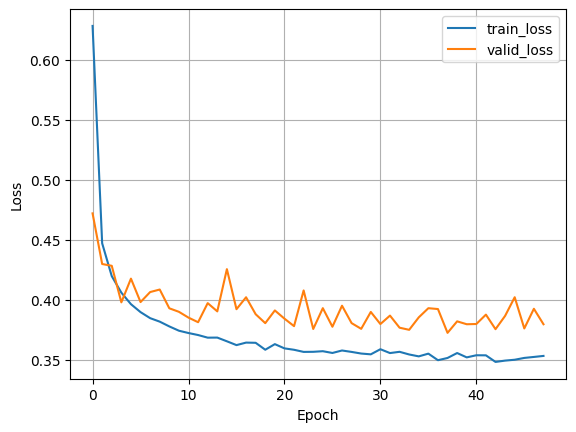

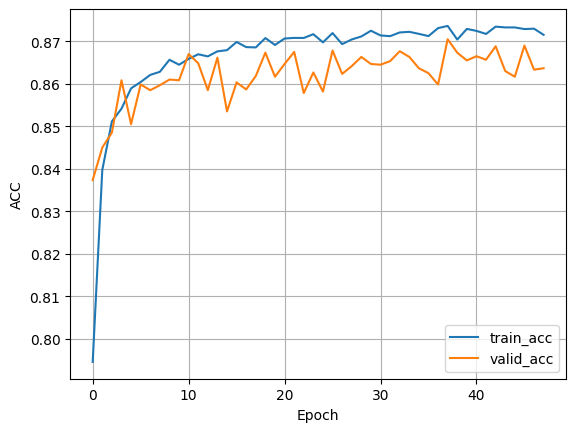

In [18]:
metrics = pd.read_csv(f"{trainer.logger.log_dir}/metrics.csv")

aggreg_metrics = []
agg_col = "epoch"
for i, dfg in metrics.groupby(agg_col):
    agg = dict(dfg.mean())
    agg[agg_col] = i
    aggreg_metrics.append(agg)

df_metrics = pd.DataFrame(aggreg_metrics)
df_metrics[["train_loss", "valid_loss"]].plot(
    grid=True, legend=True, xlabel="Epoch", ylabel="Loss"
)
df_metrics[["train_acc", "valid_acc"]].plot(
    grid=True, legend=True, xlabel="Epoch", ylabel="ACC"
)

plt.show()

## Evaluamos el mejor modelo en el grupo de test

In [19]:
trainer.test(model = pytorch_model, datamodule = data_module, ckpt_path = 'best') # cargamos el mejor checkpoint del modelo

INFO:pytorch_lightning.utilities.rank_zero:Restoring states from the checkpoint path at logs/complex-cnn-fmnist/version_22/checkpoints/epoch=37-step=32034.ckpt
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]
INFO:pytorch_lightning.utilities.rank_zero:Loaded model weights from the checkpoint at logs/complex-cnn-fmnist/version_22/checkpoints/epoch=37-step=32034.ckpt


Output()

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.8651999831199646     │
└───────────────────────────┴───────────────────────────┘

[{'test_acc': 0.8651999831199646}]